# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Giada Aggio

**ID Number**: 2089092

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2089092  # insert your ID number here
np.random.seed(ID)

Load the provided images and display them (if you like you can experiment with other images)

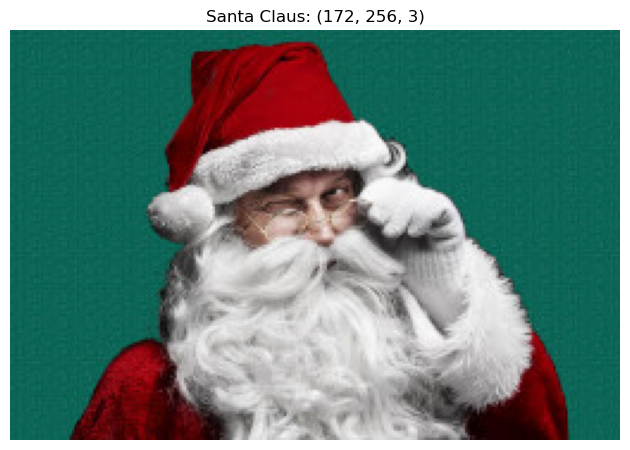

In [8]:
# To load the images use the function plt.imread(<path_to_iamge>)
santa = plt.imread('./data/santaclaus2.jpg')

# Plot the images with their shapes
# Sugestion: use the function img_plot()
img_plot(santa,'Santa Claus')

We are going to start by using the Santa Claus image.


In [9]:
# Reshape the data to a matrix of num_pixels x 3 
num_pixels = santa.shape[0]*santa.shape[1]
reshaped_santa_notnorm = np.reshape(santa, (num_pixels,3))

# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
reshaped_santa = reshaped_santa_notnorm/255

# Print the shape of the data and the min and max values of the pixels
print('shape of the data:', np.shape(reshaped_santa))
print('min value of the pixels:', np.min(reshaped_santa))
print('max value of the pixels:', np.max(reshaped_santa))

shape of the data: (44032, 3)
min value of the pixels: 0.0
max value of the pixels: 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

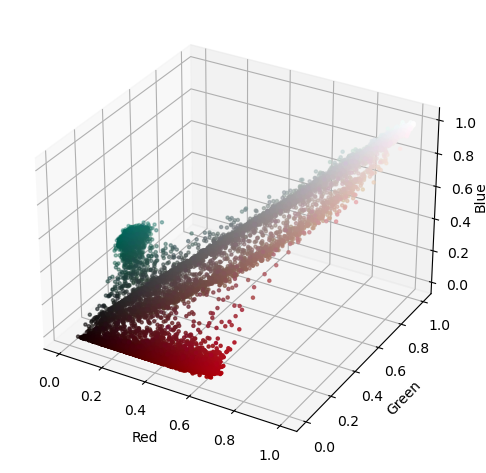

In [10]:
# Sugestion: use the function scatter_plot()
scatter_plot(reshaped_santa)

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [11]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iteration
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    
    sigma = np.std(points, axis = 0)
    mean = np.mean(points, axis = 0)
    centers = sigma * np.random.randn(k, points.shape[1]) + mean
  
    prev_error = 100000
    error = [9999]
    
    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every center
        distances = np.sqrt(((points[:, np.newaxis] - centers) ** 2).sum(axis=2))

        # Assign all training data to closest center
        clusters = np.argmin(distances, axis=1)
       
        # Calculate mean for every cluster and update the center
        new_centers = np.array([points[clusters == i].mean(axis=0) for i in range(k)])
        centers = new_centers
        
        # Update the error
        prev_error = error[-1]
        error.append(np.sum(np.min(distances, axis=1)))
        
        # Update the iteration counter
        iters += 1

    return centers, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

[9999, 18718.385774284732, 6605.595955669125, 5117.139100617558, 4963.713681398118, 4948.7085630833335, 4940.65706270721, 4933.473640572148, 4928.686346431007, 4926.4692060207435, 4925.984506520063, 4925.775275465791, 4925.775275465791]


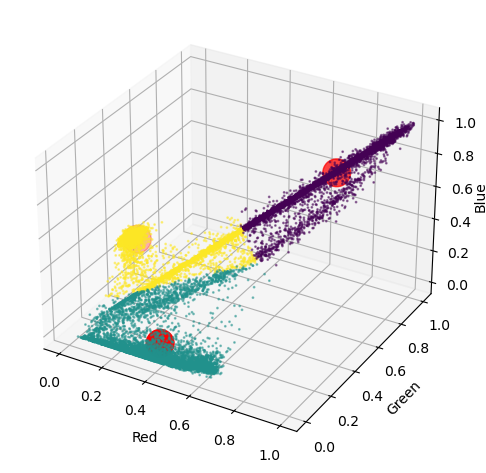

In [12]:
# Run your K-means function on the data
centers, clusters, errors = my_kmeans(reshaped_santa, 3)

# Print the errors:
print(errors)

# Plot the results
scatter_plot(reshaped_santa, clusters, centers)

### TO DO (A.3) 
Plot the value of the error versus the number of iterations

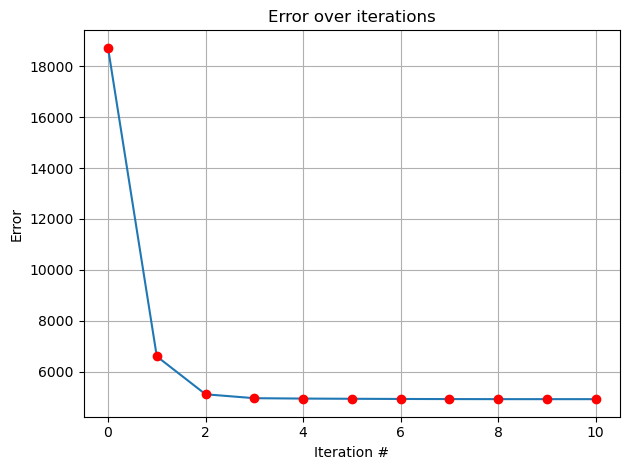

In [13]:
# Sugestion: use the function error_plot()
error_plot(errors)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [14]:
# Define the K-means model
kmeans_model = KMeans(3, init='random', n_init=10)

# Fit the model to the data
kmeans = kmeans_model.fit(reshaped_santa)
clusters_skl = kmeans_model.predict(reshaped_santa)

# Get the cluster centers
centers_skl = kmeans.cluster_centers_

Perform the same plot as above but with the output of the k-means function provided in sklearn.

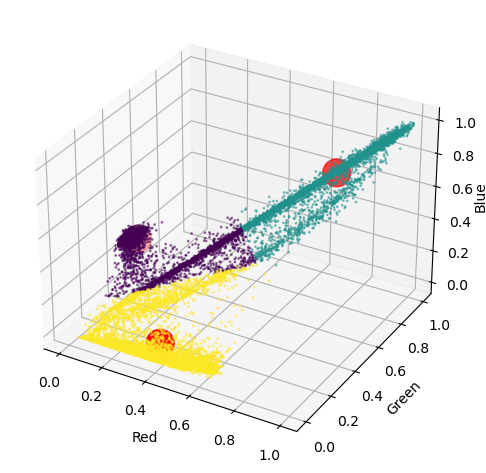

In [15]:
scatter_plot(reshaped_santa, clusters_skl, centers_skl)

### TO DO (A.Q1) [Answer the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q1:** 
<div class="alert alert-block alert-info">
There is no difference between the two plots, meaning that the manual implementation of the method works well. The only difference we can find is that the coordinates of the centers are not exactly the same but this difference is very small (they differ at the third decimal number).
</div>

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

[[ 19.97883816 100.65881675  87.50784306]
 [198.87515688 196.43388704 195.74913252]
 [100.11051952  13.85366247  17.21813488]]


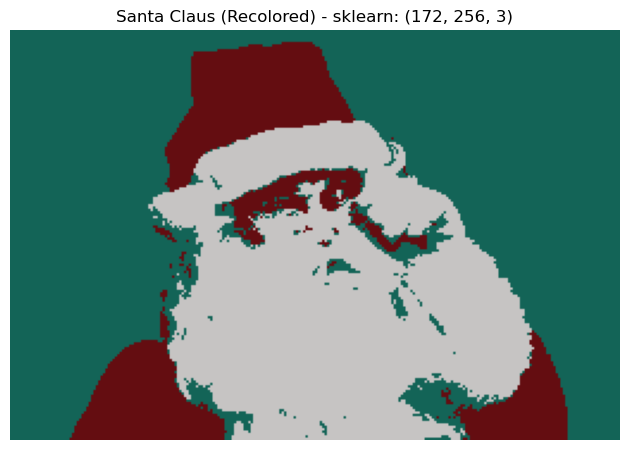

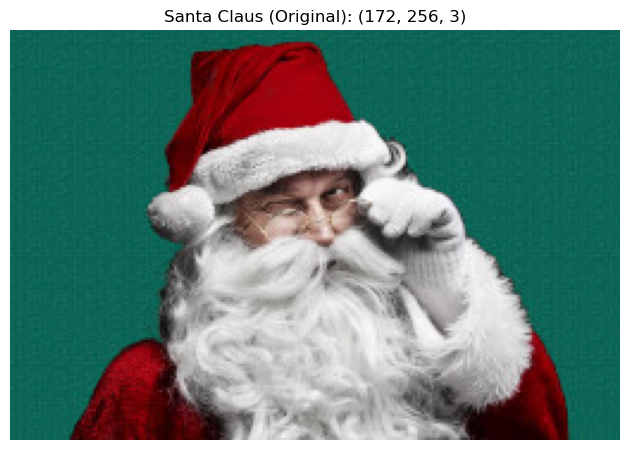

In [16]:
# Extract the color values of the centers
centers_skl_rgb = (centers_skl * 255)
print(centers_skl_rgb)

# Reshape the data to the original image shape
image_reshaped = np.reshape(clusters_skl, (santa.shape[0], santa.shape[1]))

# Plot the recolored image
recolored_santa = np.zeros_like(santa)

# assign color based on cluster centers
for i in range(santa.shape[0]):
    for j in range(santa.shape[1]):
        recolored_santa[i][j] = centers_skl_rgb[image_reshaped[i][j]]


img_plot(recolored_santa,'Santa Claus (Recolored) - sklearn')
img_plot(santa, 'Santa Claus (Original)')

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

[[198.89534712 196.46277696 195.78042836]
 [100.11978661  13.73488522  17.11445199]
 [ 20.04159467 100.6497984   87.50436106]]


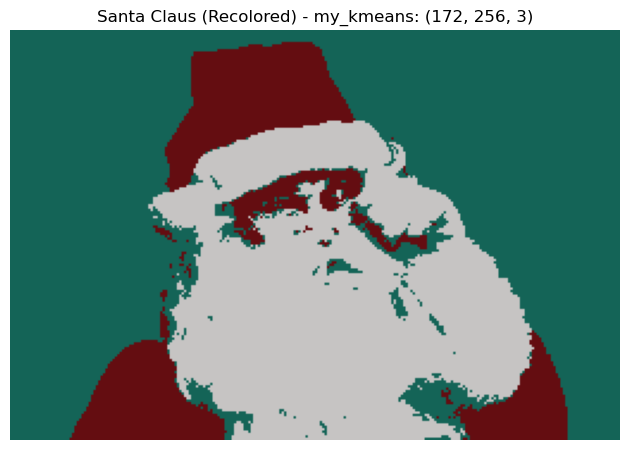

In [17]:
# Extarct the color values of the centers
centers_rgb = (centers * 255)
print(centers_rgb)

# Reshape the data to the original image shape
image_reshaped_2 = np.reshape(clusters, (santa.shape[0], santa.shape[1]))

# Plot the recolored image
recolored_santa_2 = np.zeros_like(santa)

# assign color based on cluster centers
for i in range(santa.shape[0]):
    for j in range(santa.shape[1]):
        recolored_santa_2[i][j] = centers_rgb[image_reshaped_2[i][j]]

img_plot(recolored_santa_2,'Santa Claus (Recolored) - my_kmeans')


### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q2:** 
<div class="alert alert-block alert-info">
The image has been recolored accordingly to the closest color for each pixel. Using more clusters would have been resulted in a more detailed image and with more realistic colors. <br>
    
In my opinion clustering is very useful for image segmentation in fact in this way we can see rapidly the groups of pixels with different properties, i.e. same color. 
It's useful even for image compression for the same reason since in image compression we need to group similar data into clusters and then representing the clusters using a representative value. 
</div>

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

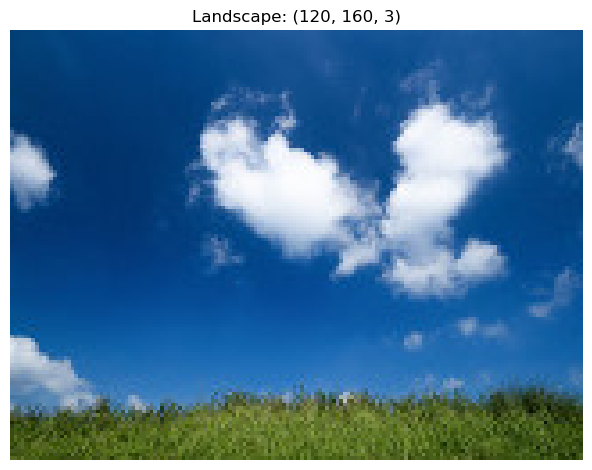

shape of the data: (19200, 3)
min value of the pixels: 0.0
max value of the pixels: 1.0

K-means clustering with different values of K (2-15):


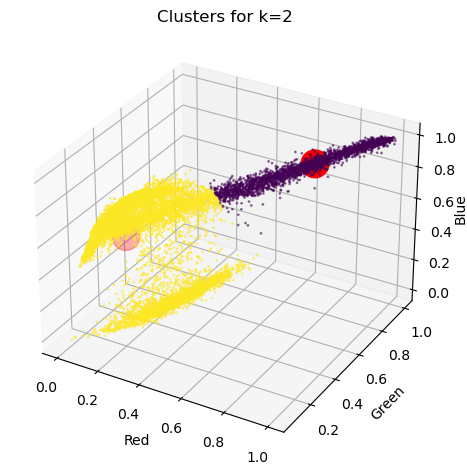

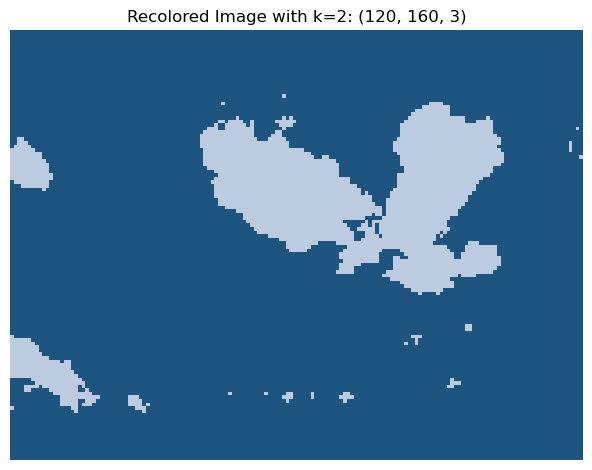

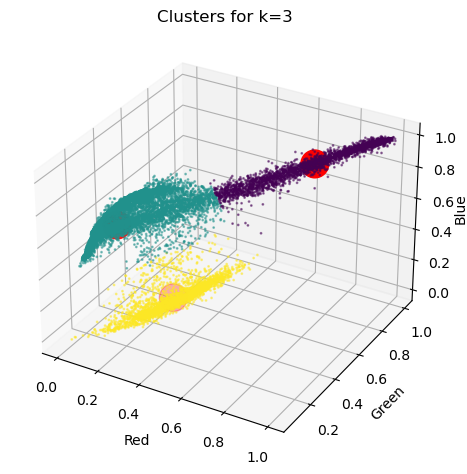

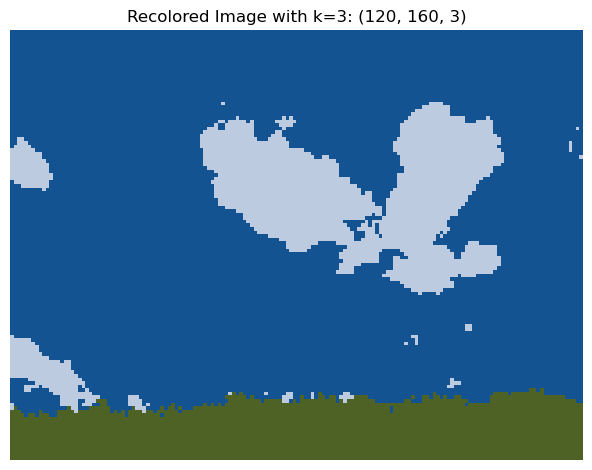

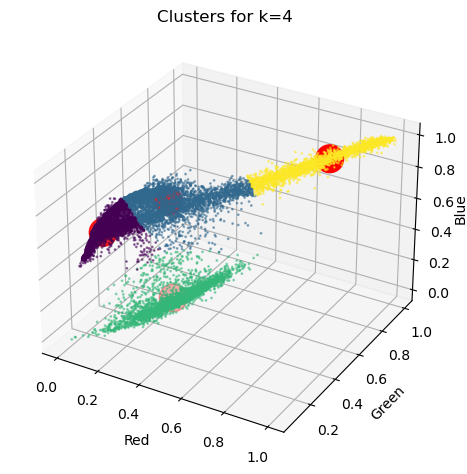

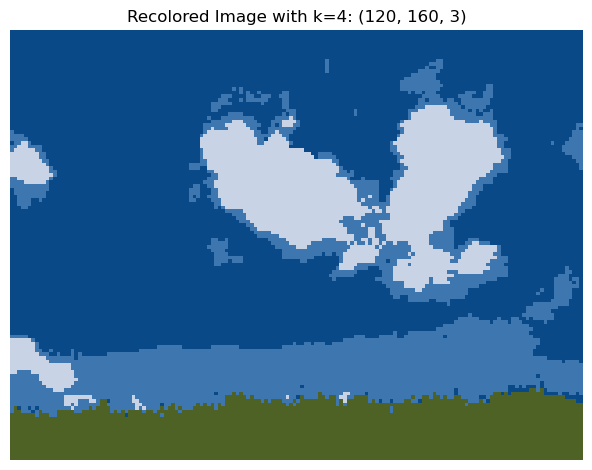

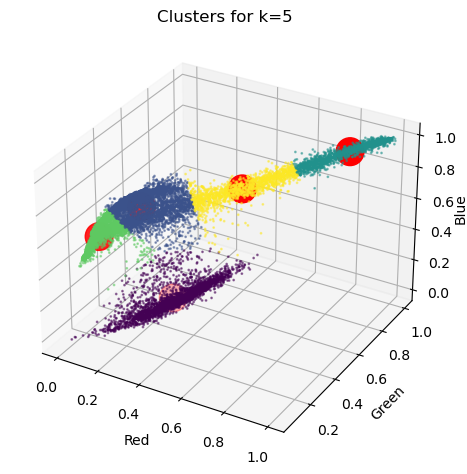

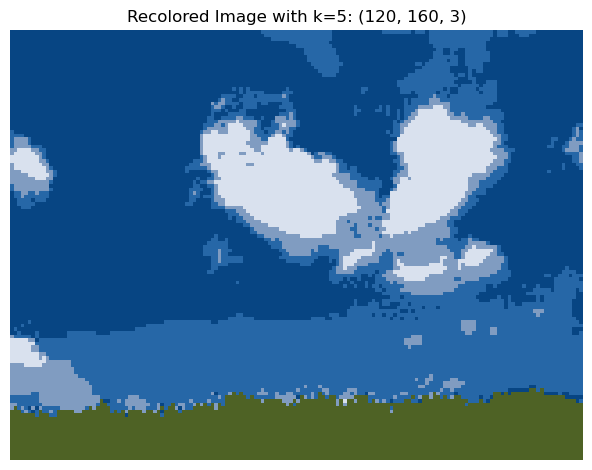

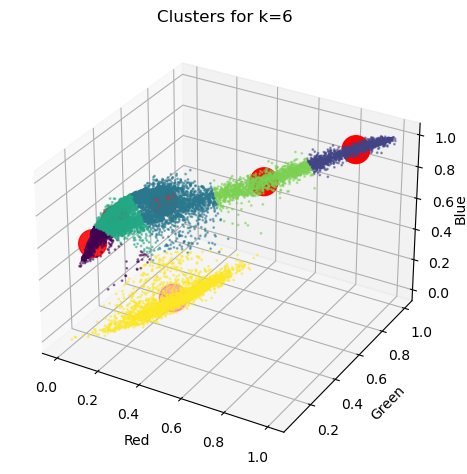

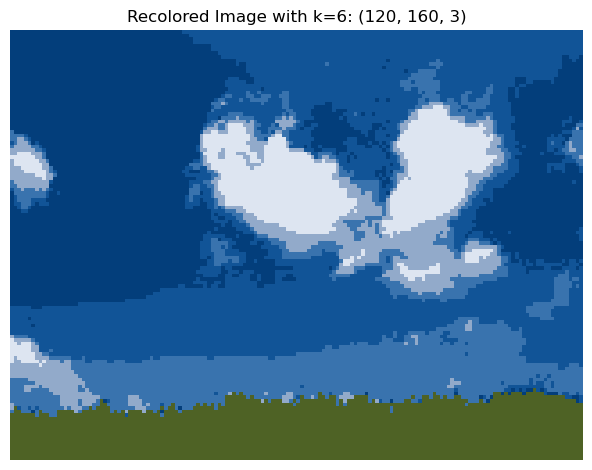

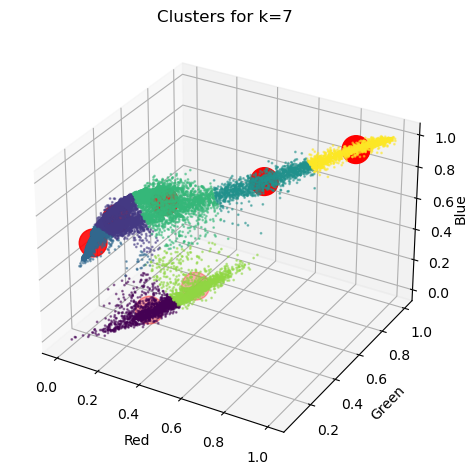

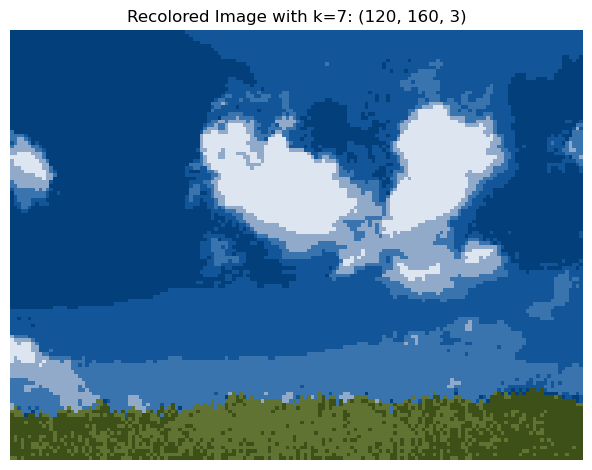

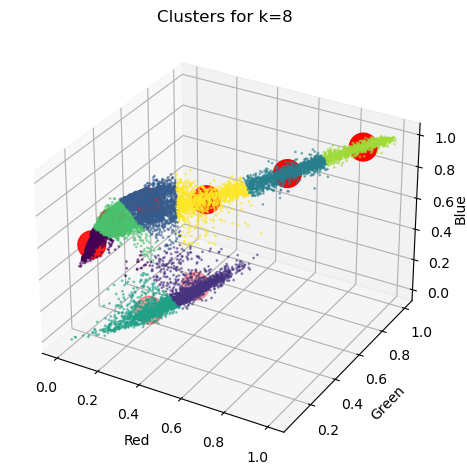

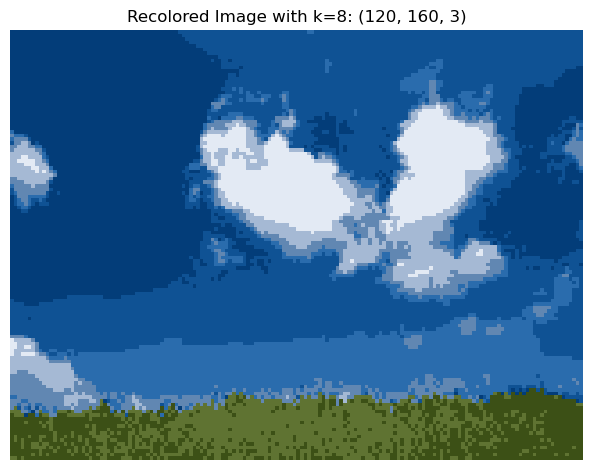

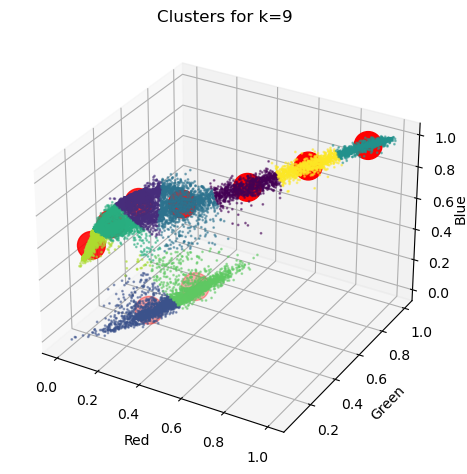

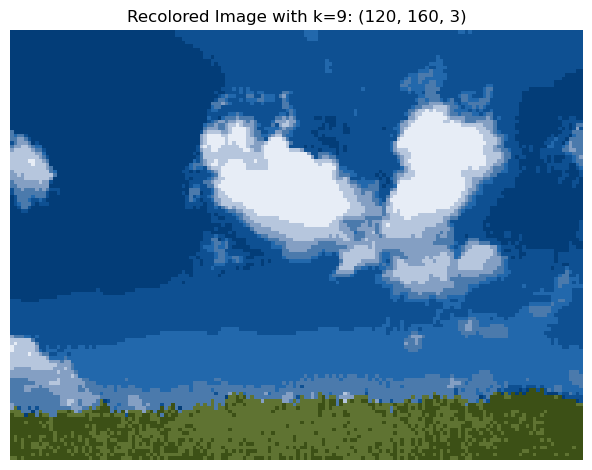

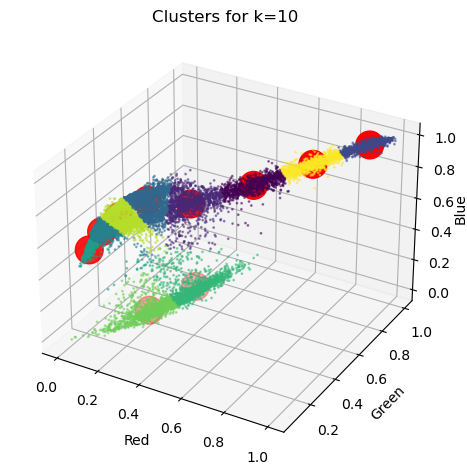

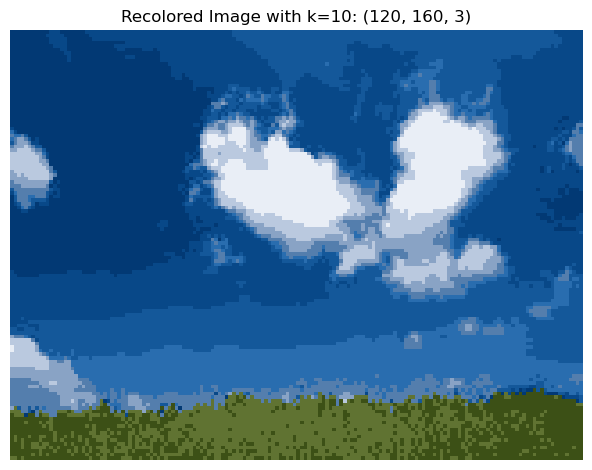

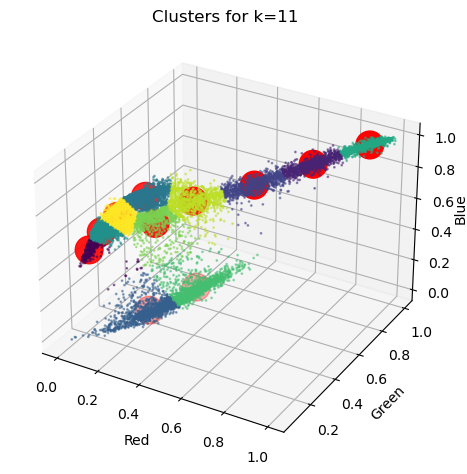

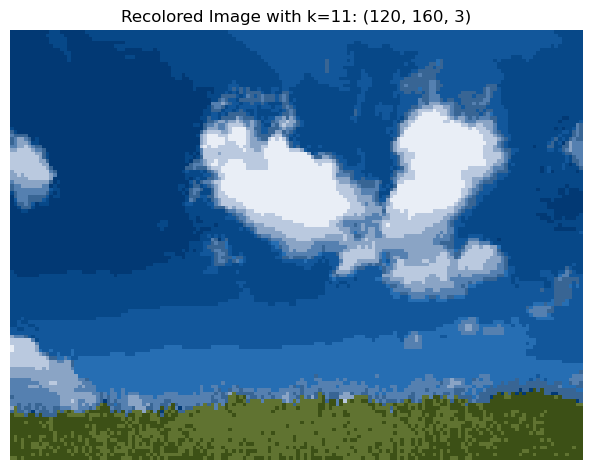

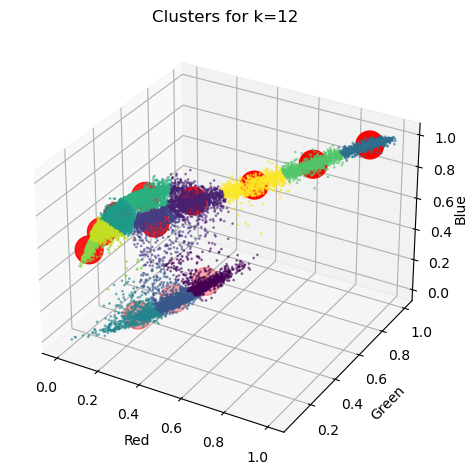

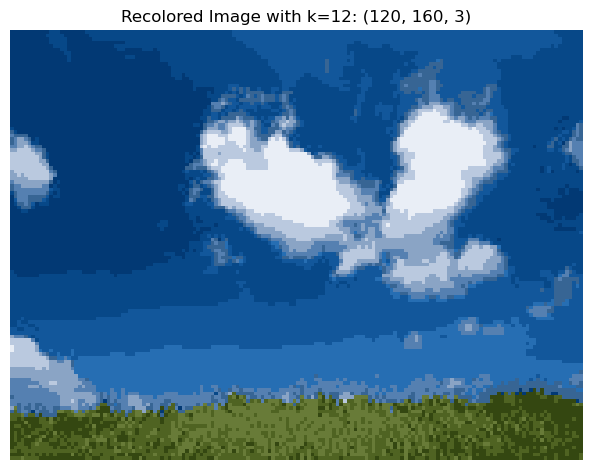

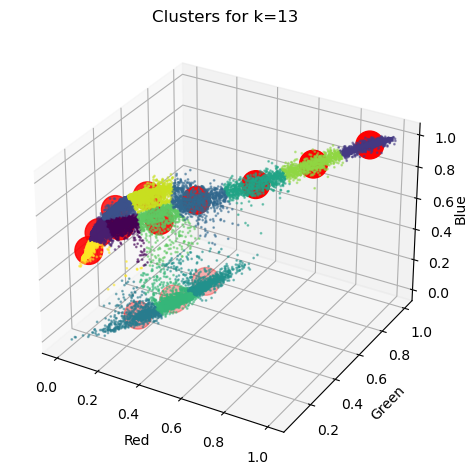

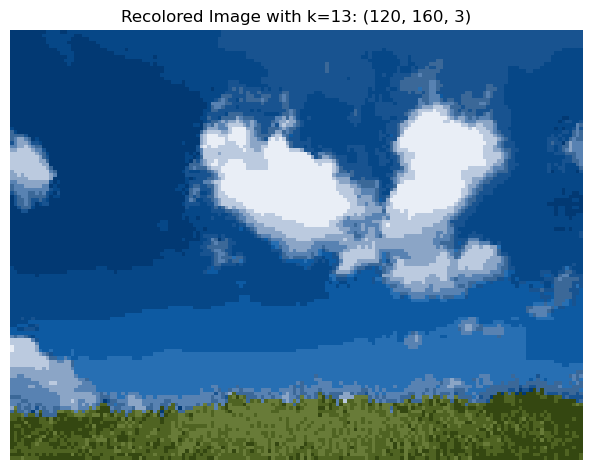

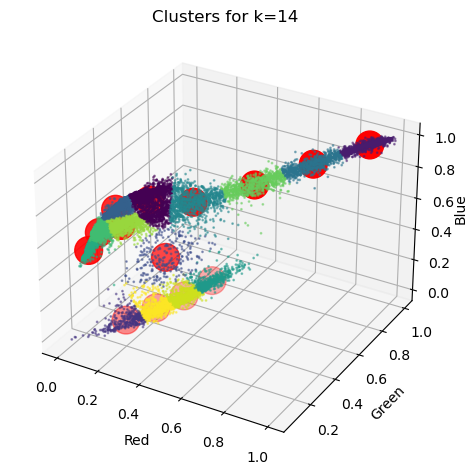

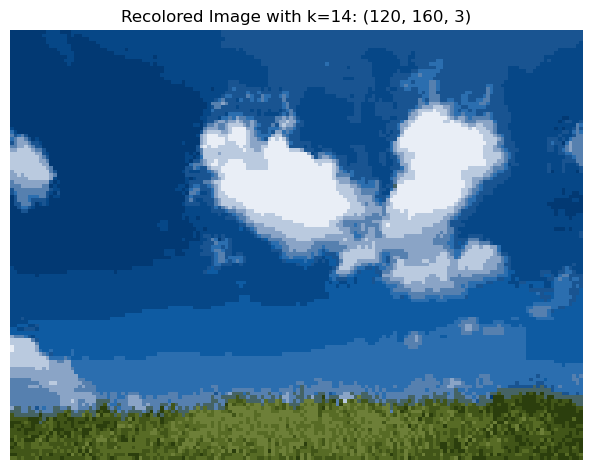

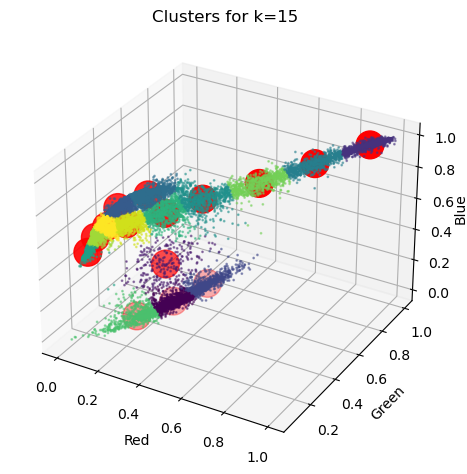

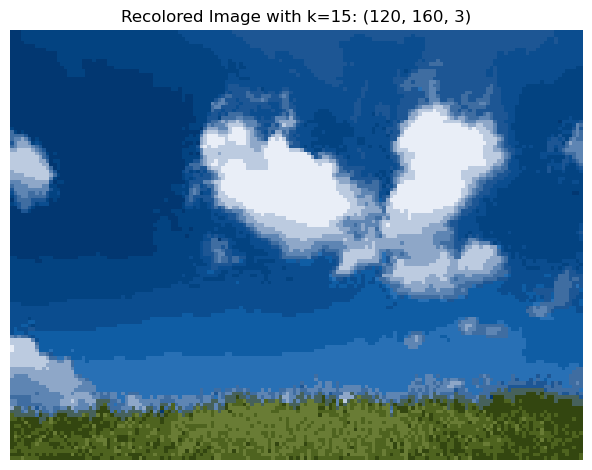

In [18]:
landscape = plt.imread('./data/landscape.jpg')

# Plot the images with their shapes
# Sugestion: use the function img_plot()
img_plot(landscape,'Landscape')

# Reshape the data to a matrix of total_num_pixels x 3

num_pixels = landscape.shape[0]*landscape.shape[1]
reshaped_landscape= np.reshape(landscape, (num_pixels,3))

# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
reshaped_landscape = reshaped_landscape/255

# Print the shape of the data and the min and max values of the pixels
print('shape of the data:', np.shape(reshaped_landscape))
print('min value of the pixels:', np.min(reshaped_landscape))
print('max value of the pixels:', np.max(reshaped_landscape))


# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    kmeans_model = KMeans(k, init='random', n_init=10)

    # Fit the model to the data
    kmeans = kmeans_model.fit(reshaped_landscape)

    # Get the cluster centers
    centers = kmeans.cluster_centers_

    # Extarct the color values of the centers
    clusters = kmeans.predict(reshaped_landscape)

    # Reshape the data to the original image shape
    image_reshaped = np.reshape(clusters, (landscape.shape[0], landscape.shape[1]))

    # Update the inertia
    inertia.append(kmeans.inertia_)     # is the error
    
    # Plot the scatter plot 
    scatter_plot(reshaped_landscape, clusters, centers, f'Clusters for k={k}')

    # Plot the recolored image
    centers_rgb = centers * 255
    image_reshaped = np.reshape(clusters, (landscape.shape[0], landscape.shape[1]))
    recolored_landscape = np.zeros_like(landscape)

    for i in range(landscape.shape[0]):
        for j in range(landscape.shape[1]):
            recolored_landscape[i][j] = centers_rgb[image_reshaped[i][j]]
            
    img_plot(recolored_landscape, f'Recolored Image with k={k}')

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

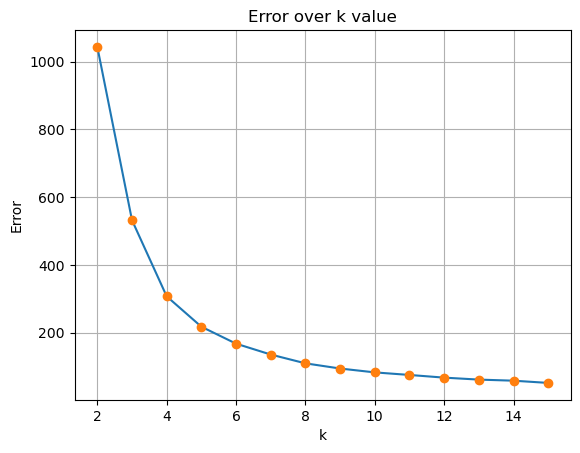

In [19]:
k = np.arange(2,16)

plt.plot(k,inertia,'-')
plt.plot(k,inertia,'o')
plt.title('Error over k value')
plt.xlabel('k')
plt.ylabel('Error')
plt.grid(True)

### TO DO (AQ.3) [Answer the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** 

<div class="alert alert-block alert-info">
Using different values of k we can observe that the more k we use, the better the image is recolored. This is obvious since if we select a lots of clusters the pixels will be categorized in a better way. <br>

Looking at the error we can't tell if there is an optimal value of k since the error diminishes exponentially. We can just say that is better to use higher values of k so that we're in a win-win situation: a good recolored image and a low error. 
</div>

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [20]:
# Load sample data
data = np.load('./data/moon_data.npz')

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from sklearn on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [21]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
model = AgglomerativeClustering(linkage='single')

# Fit the model to the data
clustering = model.fit(x)

# Compute the number of clusters in labels, ignoring noise if present.
labels = clustering.labels_

# Print the results
print('Number of clusters:', model.n_clusters_, '\nLabels:', labels)

Number of clusters: 2 
Labels: [1 0 1 ... 1 0 1]


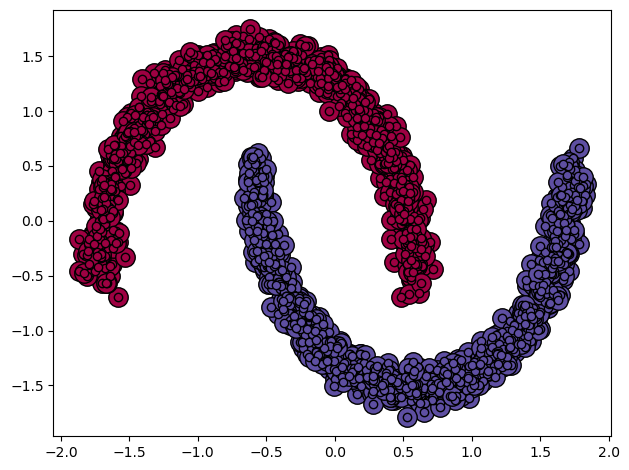

In [22]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(labels, x)

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

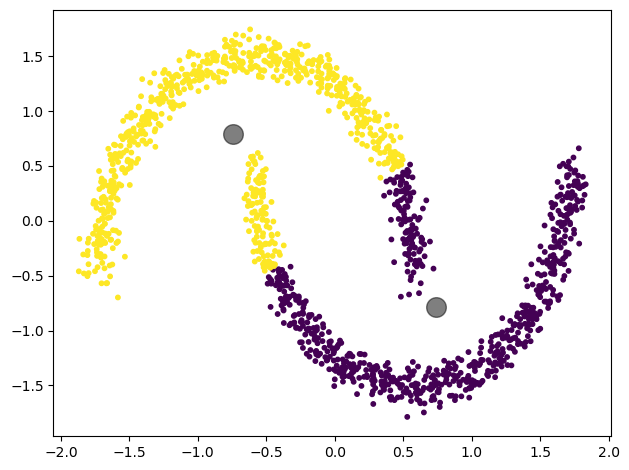

In [23]:
# Define the K-means model
model_kmeans = KMeans(2, init='random', n_init=10)

# Fit the model to the data
kmeans = model_kmeans.fit(x)
clusters = model_kmeans.predict(x)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Extarct the color values of the centers ???

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x,clusters,centers)

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** 
<div class="alert alert-block alert-info">
Looking at the results of these two methods is clear that the Agglomerative Clustering works way better on these kind of data. This is due to the fact that the K-Means forces sperical symmetry of clusters in the n-dimensional space and even on the position of the initial centroids. <br>

This doesn't happen when using the Agglomerative Clustering since in this method we don't have to choose inital centroids but every point is considered a single cluster. In this way there won't be any chanche for one of the points of the lower "halfmoon" to be inserted in the upper "halfmoon" since they're too far away from each other. 
</div>